In [5]:
#Instalações e imports

!pip install pyspark py4j
!pip install findspark

from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import * 
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import rand, randn
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from google.colab import drive

import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 23.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=278cc000ac6281316e2b341f04bf05a0bd64a8e69ac353404f3fffa4ada8dcf8
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
#Criação da SparkSession
conf= SparkConf().setAppName('WorldPopulationPrediction').setMaster('local[*]')
sc= SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

In [7]:
#Mount da google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#Configuração para o spark conseguir ler o ficheiro csv do dataset
df = spark.read.format("csv").option("header","true")\
.option("inferSchema","true").load("../content/drive/MyDrive/Colab Notebooks/pop_tot.csv")

In [9]:
#Leitura do ficheiro csv e atribuição à variável df
df=spark.read.csv('../content/drive/MyDrive/Colab Notebooks/pop_tot.csv',inferSchema=True,header=True)

In [ ]:
#Verificação dos tipos de variáveis
df.dtypes

In [10]:
#Alteração do tipo de variável string -> int
year_string = df.columns[4:34]

for c in year_string:
  df = df.withColumn(c, F.col(c).cast('Integer'))

In [11]:
#Drop de 4 colunas e de quaisquer valores nulos
bd=df.drop('Country Name', 'Country Code', 'Indicator Name', 'Indicator Code').dropna(how ='any')

In [ ]:
#Verificação de valores null
missing_values = []

for col in bd.columns:
    missing_values.append((col, bd.filter(bd[col].isNull()).count()))

for col, val in missing_values:
    if val == 0:
        print("{} : Nenhum missing values encontrado".format(col))
    else:
        print("{} : {} missing values".format(col, val))

In [269]:
#Criação do vetor
vector_col = 'features'

years=['1960','1961','1962','1963','1964','1965','1966','1967','1968','1969',
      '1970','1971','1972','1973','1974','1975','1976','1977','1978','1979',
      '1980','1981','1982','1983','1984','1985','1986','1987','1988','1989',
      '1990','1991','1992','1993','1994','1995','1996','1997','1998','1999',
      '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009',
      '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019',
      '2020','2021']

assembler = VectorAssembler(inputCols=years, outputCol=vector_col)

In [212]:
#Aplicação do vetor ao dataset em uso 
df_vector = assembler.transform(bd)

In [213]:
#Visualização do dataframe criado acima com a coluna do vetor
df_vector

DataFrame[1960: int, 1961: int, 1962: int, 1963: int, 1964: int, 1965: int, 1966: int, 1967: int, 1968: int, 1969: int, 1970: int, 1971: int, 1972: int, 1973: int, 1974: int, 1975: int, 1976: int, 1977: int, 1978: int, 1979: int, 1980: int, 1981: int, 1982: int, 1983: int, 1984: int, 1985: int, 1986: int, 1987: int, 1988: int, 1989: int, 1990: bigint, 1991: bigint, 1992: bigint, 1993: bigint, 1994: bigint, 1995: bigint, 1996: bigint, 1997: bigint, 1998: bigint, 1999: bigint, 2000: bigint, 2001: bigint, 2002: bigint, 2003: bigint, 2004: bigint, 2005: bigint, 2006: bigint, 2007: bigint, 2008: bigint, 2009: bigint, 2010: bigint, 2011: bigint, 2012: bigint, 2013: bigint, 2014: bigint, 2015: bigint, 2016: bigint, 2017: bigint, 2018: bigint, 2019: bigint, 2020: bigint, 2021: bigint, features: vector]

In [215]:
#Visualização das primeiras 5 linhas da coluna features (vetor) 
df_vector.select('features').show(5,False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                

In [ ]:
#Cálculo da correlação entre variável
matrix = Correlation.corr(df_vector,vector_col).collect()[0][0]

In [ ]:
#Criação da matrix
corrmatrix = matrix.toArray().tolist()

In [ ]:
#Criação do dataframe para ver a correlação entre váriaveis (anos)
df_corr=spark.createDataFrame(corrmatrix, years)

In [187]:
#Visualização das primeiras 5 linhas das primeiras 5 colunas do dataframe de correlação
df_corr.select(df_corr.columns[0:5]).show(5)

+------------------+------------------+------------------+------------------+------------------+
|              1960|              1961|              1962|              1963|              1964|
+------------------+------------------+------------------+------------------+------------------+
|               1.0|0.9999368591031376|0.9998614345641724|0.9998344804913336|0.9997713959109056|
|0.9999368591031376|               1.0|0.9999824904069208|0.9999525659207149|0.9998920533699658|
|0.9998614345641724|0.9999824904069208|               1.0| 0.999984748934919|0.9999409633790446|
|0.9998344804913336|0.9999525659207149| 0.999984748934919|               1.0|0.9999856601372521|
|0.9997713959109056|0.9998920533699658|0.9999409633790446|0.9999856601372521|               1.0|
+------------------+------------------+------------------+------------------+------------------+
only showing top 5 rows



In [271]:
#Criação do modelo para depois ser usado nos métodos de ML
model_df=df_vector.select('features','2021')

In [272]:
#Verificação de quantas linhas e colunas tem o nosso modelo
print((model_df.count(), len(model_df.columns)))

(259, 2)


In [273]:
#RandomSplit dos dados de treino (70%) e de teste (30%)
train_df,test_df=model_df.randomSplit([0.7,0.3])

In [ ]:
#Descrição do dataframe dos dados de treino
train_df.describe().show()

+-------+--------------------+
|summary|                2021|
+-------+--------------------+
|  count|                 186|
|   mean|1.9599317723118278E8|
| stddev| 5.195612910866716E8|
|    min|               11204|
|    max|          3411889059|
+-------+--------------------+



In [ ]:
#Descrição do dataframe dos dados de teste
test_df.describe().show()

+-------+-------------------+
|summary|               2021|
+-------+-------------------+
|  count|                 73|
|   mean| 2.31975152369863E8|
| stddev|5.627954086661571E8|
|    min|              45035|
|    max|         2503136362|
+-------+-------------------+



In [ ]:
#Criação do objeto StandardScaler e aplicação nos conjuntos de treino e de teste
scaler = StandardScaler(inputCol='features', outputCol='standard_features')
scaler_model = scaler.fit(train_df)
train = scaler_model.transform(train_df)
test = scaler_model.transform(test_df)

In [ ]:
#Visualização das primeiras 2 linhas da coluna standard_features de ambos os dataframes
train.select('standard_features').show(2,truncate=False)
test.select('standard_features').show(2,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Regressão Linear**

In [ ]:
#Criação do objeto LinearRegression, treinamento do modelo com os dados de treino e realizações de previsões com os dados de teste
lin_Reg=LinearRegression(featuresCol='standard_features', labelCol='2021')
model = lin_Reg.fit(train)
predictions = model.transform(test)

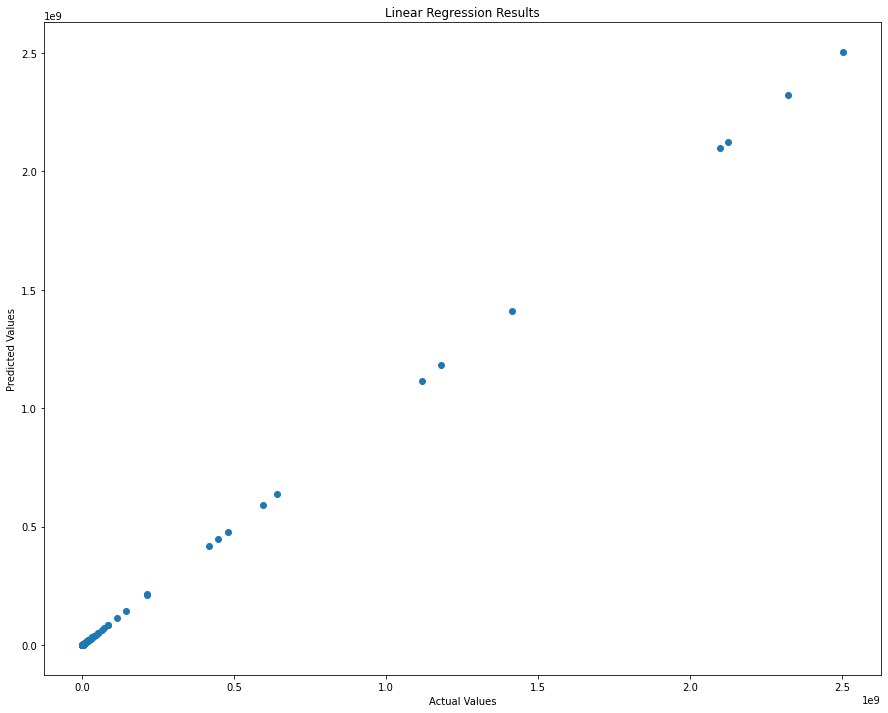

In [ ]:
#Realização das previsões passando para um dataframe (.toPandas())
y_actual = predictions.select('2021').toPandas()
y_pred = predictions.select('prediction').toPandas()

#Criação do gráfico dos resultados das predições do modelo
plt.figure(figsize=(15, 12))

plt.scatter(y_actual, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Results')
plt.show()

In [ ]:
#Cálculo da inclinação dos dados, ou seja, se eles tiverem muita correlação vai ser perto de 0 e vice versa.
model.intercept

-0.017620730485301217

In [ ]:
#Visualização dos coeficientes do modelo
model.coefficients

DenseVector([-256.3787, 770.9063, -2419.8233, 3756.1274, -2133.1664, 1011.0412, -2714.5361, 3896.1918, -3013.1297, 1028.742, 265.377, -364.2411, 1406.7661, -2322.1513, 1658.3034, -1504.5825, 2110.55, -1958.6209, 1879.9168, -2562.1672, 2824.6999, -3741.9958, 5843.9907, -6738.9379, 7581.7246, -8854.9566, 6097.3441, -1187.3771, 17.8652, -501.7796, -424.0127, 454.0463, 626.0097, -737.318, 1174.4271, -3575.3196, 7387.8379, -9923.8815, 7700.0838, -2401.9443, -930.9493, 2333.8302, -7159.9644, 12051.5494, -9389.281, 3488.6988, -1013.2222, 1268.6838, -1196.3463, 631.3443, -699.2034, 601.8251, 199.0446, -1150.9301, 2555.8632, -4404.1356, 5443.6744, -5167.3657, 4064.2439, -2842.3974, 1719.7639, 519560730.6119])

In [ ]:
#Avaliação das previsões dos dados de treino 
training_predictions=model.evaluate(train)

In [ ]:
#Média dos erros quadrados das previsões dos dados de treino
training_predictions.meanSquaredError

0.015355086903428206

In [ ]:
#Visualização de erros residuais baseados em previsões
test_results=model.evaluate(test)
test_results.residuals.show(10)

+--------------------+
|           residuals|
+--------------------+
|0.019640428479760885|
|-0.02897854543698486|
| 0.01815541135147214|
|  0.0164890568703413|
|0.016210419315029867|
|0.020141168672125787|
|0.016596433706581593|
|0.015631805872544646|
| 0.25315048173069954|
|-0.00241298577748...|
+--------------------+
only showing top 10 rows



In [178]:
#Média dos erros quadrados dos resultados dos dados de teste
test_results.meanSquaredError

0.10743216502044732

In [ ]:
#Raiz quadrada da média dos erros quadrados dos resultados dos dados de teste
test_results.rootMeanSquaredError

0.327768462516526

In [4]:
#Cálculo do score do modelo ML 
Score=1-0.327768462516526
print(Score)

0.672231537483474


O nosso modelo de regressão linear tem uma precisão de 67.22%

## **Clustering**

In [262]:
#Criação e aplicação do modelo KMeans aos dados de treino
errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(train)
    sse = model.summary.trainingCost
    errors.append(sse)
    print("With K={}".format(k))
    print("Within Set Sum of Squared Errors = " + str(sse))
    print('--'*30)

With K=2
Within Set Sum of Squared Errors = 3.847326600115323e+20
------------------------------------------------------------
With K=3
Within Set Sum of Squared Errors = 1.8597556936888848e+20
------------------------------------------------------------
With K=4
Within Set Sum of Squared Errors = 6.004908317885996e+19
------------------------------------------------------------
With K=5
Within Set Sum of Squared Errors = 3.834910224250044e+19
------------------------------------------------------------
With K=6
Within Set Sum of Squared Errors = 3.0680555214319387e+19
------------------------------------------------------------
With K=7
Within Set Sum of Squared Errors = 2.1583962574696727e+19
------------------------------------------------------------
With K=8
Within Set Sum of Squared Errors = 1.7811907121401848e+19
------------------------------------------------------------
With K=9
Within Set Sum of Squared Errors = 1.9625454034482557e+19
----------------------------------------

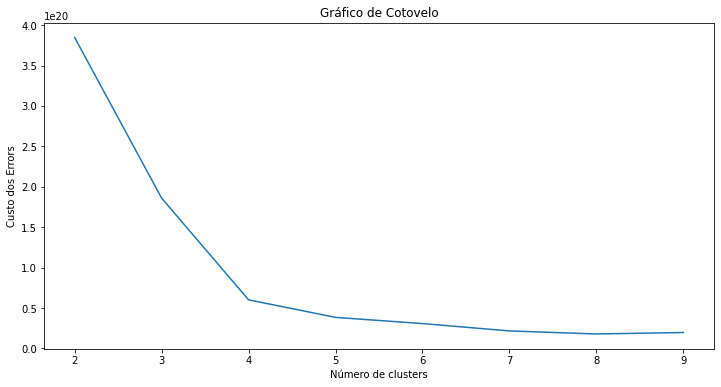

In [263]:
#Criação do gráfico de cotovelo
plt.figure(figsize=(12, 6))

plt.plot(range(2,10), errors)
plt.xlabel('Número de clusters')
plt.ylabel('Custo dos Errors')
plt.title('Gráfico de Cotovelo')
plt.show()

In [261]:
#Verificação dos dados dentro de cada clusters
centers = model.clusterCenters()
i=1
print("Cluster Centers: ")
for center in centers:
  print("Cluster " + str(i))
  print(center)
  i+=1

Cluster Centers: 
Cluster 1
[ 7215415.47096774  7348197.30322581  7485584.8516129   7626310.34193548
  7770244.17419355  7914607.65806452  8058425.83225806  8206932.92903226
  8357372.72903226  8506416.66451613  8652645.94193548  8805535.6516129
  8954876.83870968  9111681.18709677  9272376.13548387  9433019.97419355
  9592180.08387097  9752066.3483871   9911142.30322581 10072759.48387097
 10237735.96129032 10413499.14193548 10595071.77419355 10773179.40645161
 10950948.14193548 11128567.98709677 11308980.13548387 11492862.72258065
 11676789.28387097 11859622.99354839 12047613.92258064 12238471.22580645
 12418912.93548387 12592092.23870968 12759354.58064516 12925099.40645161
 13094152.81290323 13260071.59354839 13424027.97419355 13589377.43225806
 13753868.98064516 13922464.94193548 14093501.14193548 14269866.93548387
 14452058.61290323 14637729.79354839 14825786.60645161 15016480.65806452
 15214822.83870968 15416212.63870968 15616623.69032258 15823249.26451613
 16034396.84516129 16259